In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-pro")

In [8]:
from langchain_core.tools import tool 
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


# Replace 'YOUR_APP_ID' with your actual Wolfram Alpha API key
app_id = 'KWW3UE-KE799U2QKY'

@tool 
def graph_plot(query: str) -> str:
    '''
    function for plotting the graph for the given mathematical function or equation, in text format. Takes a single expression at a time.

    Args:
        query: str - the query of mathematical function or equation, which needs to plotted.
    Returns:
        str - whether the plot is successfully plotted or not.
    '''
# URL for the Wolfram Alpha API
    url = f'http://api.wolframalpha.com/v2/query?input={query}&format=image,plaintext&output=JSON&appid={app_id}'

    # Send the request to the API
    response = requests.get(url)
    data = response.json()

    try:
        # Extract the image URL from the response
        pods = data['queryresult']['pods']
        image_url = None
        for pod in pods:
            if 'plot' in pod['title'].lower():
                subpods = pod['subpods']
                for subpod in subpods:
                    if 'img' in subpod:
                        image_url = subpod['img']['src']
                        break
                if image_url:
                    break
        
        # Check if an image URL was found
        print(image_url)
        if image_url:
            # Download the image
            image_response = requests.get(image_url)
            img = Image.open(BytesIO(image_response.content))

            # Display the image using Matplotlib
            plt.imshow(img)
            plt.axis('off')  # Hide the axes
            plt.show()
            return "Plot succesfully plotted"
        else:
            return "No plot found in the query result."
    except Exception as e:
        print(e)
        return "No plot found"

@tool
def show_steps(query: str) -> str:
    '''
    function for solving a mathematical expression or equation, and providing each steps for the solution.

    Args:
        query: str - the mathematical query, in the form of expression or equation which needs to be solved.
    
    Returns:
        str - solution with complete steps of solution
    '''
    url = f'http://api.wolframalpha.com/v2/query?input={query}&podstate=Result__Step-by-step+solution&format=plaintext&output=JSON&appid={app_id}'

    # Send the request to the API
    response = requests.get(url)
    data = response.json()

    # Extract the solution steps from the response
    message = ""
    steps = []
    pods = data['queryresult']['pods']
    for pod in pods:
        if 'Solution' in pod['title'] or 'Result' in pod['title']:
            subpods = pod['subpods']
            for subpod in subpods:
                if 'plaintext' in subpod:
                    steps.append(subpod['plaintext'])

    # Check if solution steps were found
    if steps:
        message += "Solution Steps:\n"
        for step in steps:
            message += step + "\n"
    else:
        message += "No solution steps found in the query result."
    
    return message


In [9]:
tool_list = [graph_plot, show_steps]

model_with_tools = llm.bind_tools(tool_list)

In [11]:
from langchain_core.messages import HumanMessage

response = model_with_tools.invoke([HumanMessage(content="4x - 3y = 2, and 2y + 3x = 7 and solve the equation")])

print(f"Content String: {response.content}")
print(f"ToolCalls: {response.tool_calls}")

Content String: 
ToolCalls: [{'name': 'show_steps', 'args': {'query': '4x - 3y = 2\\n2y + 3x = 7'}, 'id': '86e1952b-17c7-450b-a035-8e7060d6b77a'}]


In [15]:
print(llm.invoke([HumanMessage(content="4x - 3y = 2, and 2y + 3x = 7 and solve the equation")]).content)

Given equations:
4x - 3y = 2
2y + 3x = 7

To solve this system of linear equations, we can use the substitution method.

1. Solve the first equation for x:
4x - 3y = 2
4x = 3y + 2
x = (3y + 2)/4

2. Substitute the expression for x from step 1 into the second equation:
2y + 3x = 7
2y + 3((3y + 2)/4) = 7
2y + (9y + 6)/4 = 7

3. Simplify and solve for y:
2y + (9y + 6)/4 = 7
8y + 9y + 6 = 28
17y = 22
y = 22/17

4. Substitute the value of y back into the expression for x from step 1:
x = (3y + 2)/4
x = (3(22/17) + 2)/4
x = (66/17 + 2)/4
x = 11/17

So, the solution to the system of equations is:
x = 11/17
y = 22/17


In [13]:
response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'show_steps', 'arguments': '{"query": "4x - 3y = 2\\\\n2y + 3x = 7"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-3534f533-17f2-4a06-b978-4c4620703d5e-0', tool_calls=[{'name': 'show_steps', 'args': {'query': '4x - 3y = 2\\n2y + 3x = 7'}, 'id': '86e1952b-17c7-450b-a035-8e7060d6b77a'}])

In [15]:
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

prompt_1 = ChatPromptTemplate.from_template(
    """
Given the mathematical query, write the best set of equations, expressions or functions 
which can be plotted or shown in the graph which are relevant to the solution or procedure of the 
original query. Include some guidelines to guide the plot or graph making process to showcase solution.

Query: {query}
"""
)

In [16]:
chain_1 = LLMChain(llm=llm, prompt=prompt_1)

In [17]:
resp = chain_1.run("4x - 3y = 2, and 2y + 3x = 7")

In [34]:
prompt_2 = ChatPromptTemplate.from_template(
    """
Based on the given guidelines, write Python code for plotting the graph. You 
can use libraries - matplotlib, seaborn, pandas or numpy. (not necessary to use all). 
If there is an intersection or solution point/s, be extra careful to calculate the point/s 
and use the expressions, equations or functions to calculate these point/s.

Guideline: {guideline}
"""
)

chain_2 = LLMChain(llm=llm, prompt=prompt_2)

In [35]:
from langchain.chains import SimpleSequentialChain

simple_chain = SimpleSequentialChain(
    chains=[chain_1, chain_2], 
    verbose=True
)

In [36]:
response = simple_chain.run("4x - 3y = 2, and 2y + 3x = 7")



> Entering new SimpleSequentialChain chain...
**Equations:**

* 4x - 3y = 2
* 2y + 3x = 7

**Guidelines for Plotting:**

1. **Rearrange Equations:** Solve both equations for y:
    * y = (4/3)x - 2/3
    * y = (-3/2)x + 7/2

2. **Plot Lines:** Graph each equation as a line on the same coordinate plane.
    * For the first equation: y = (4/3)x - 2/3, use points such as (0, -2/3) and (3, 4).
    * For the second equation: y = (-3/2)x + 7/2, use points such as (0, 7/2) and (2, 1).

3. **Determine Intersection:** The point where the two lines intersect is the solution to the system of equations. Find the coordinates of this point by solving the two equations simultaneously.
```python
import numpy as np
import matplotlib.pyplot as plt

# Rearrange equations for y
eq1 = lambda x: (4/3)*x - 2/3
eq2 = lambda x: (-3/2)*x + 7/2

# Generate data points for each line
x = np.linspace(-5, 5, 100)
y1 = eq1(x)
y2 = eq2(x)

# Plot the lines
plt.plot(x, y1, label="4x - 3y = 2")
plt.plot(x, y2, label="

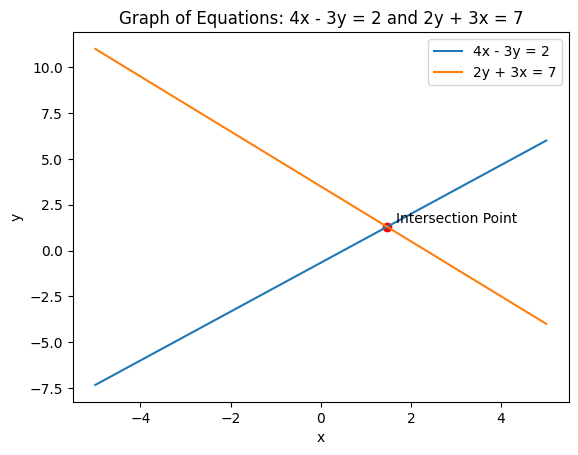

In [37]:
exec(response.replace("`", "").replace("python", ""))